# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training and Validation</a>
+ <a href='#testing'>4 Testing</a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# from keras import optimizers
# from keras.models import Sequential
# from keras.layers import TimeDistributed, Flatten
# from keras.layers.core import Dense, Dropout, Activation
# from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
#warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# from keras.models import load_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from tqdm import tqdm

C:\Users\CallO\AppData\Local\Temp\ipykernel_24316\2410309670.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral') # Colour map (there are many others)


# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [2]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [6]:
df[df[0]==1]

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,NaN,NaN
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,NaN,NaN
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,NaN,NaN
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,NaN,NaN


In [7]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [8]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [9]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [10]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [11]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                 "Section-1",
                 "Section-2",
                 "Section-3",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [12]:
df.head()

,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [13]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
# pt = PowerTransformer()
# df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [14]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500
20627,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197
20628,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991
20629,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466


In [15]:
df=np.nan_to_num(df)

In [16]:
df

array([[0.18373494, 0.40680183, 0.30975692, ..., 0.33333333, 0.71317829,
        0.7246617 ],
       [0.28313253, 0.4530194 , 0.35263336, ..., 0.33333333, 0.66666667,
        0.73101353],
       [0.34337349, 0.36952256, 0.37052667, ..., 0.16666667, 0.62790698,
        0.62137531],
       ...,
       [0.66566265, 0.68497929, 0.77532073, ..., 0.83333333, 0.23255814,
        0.05399061],
       [0.60843373, 0.74602136, 0.74746793, ..., 0.58333333, 0.11627907,
        0.23446562],
       [0.79518072, 0.63963375, 0.84216745, ..., 0.66666667, 0.17829457,
        0.21817178]])

In [17]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data 

# <a id='training_and_validation'>3. Training and Validation using LSTM</a>
<a href='#index'>Go back to Index</a>

In [18]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


In [15]:
X_train = np.array(df)

y_train = np.array(RUL_df()).reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


print(X_train.shape,y_train.shape)

(20631, 14) (20631, 1)


In [16]:
y_train

array([[192],
       [191],
       [190],
       ...,
       [  3],
       [  2],
       [  1]], dtype=int64)

In [17]:
print(max_cycles)
print(sum(max_cycles))
count = 0
for cycle_len in max_cycles:
    for i in range(21):
        y_train[count+i] = 0
    count = count + cycle_len
print(count)

[192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 135 341 155 258 283 336 202 156 185 200]
20631
20631


In [18]:
print(y_train)

[[0]
 [0]
 [0]
 ...
 [3]
 [2]
 [1]]


In [19]:
def create_dataset(X, look_back=20):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)


X_train = create_dataset(X_train)
y_train = y_train[21:]

In [20]:
print(X_train.shape,y_train.shape)

(20610, 20, 14) (20610, 1)


In [21]:
print(y_train)

[[171]
 [170]
 [169]
 ...
 [  3]
 [  2]
 [  1]]


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, feature_size):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=feature_size, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        
        # Dense layers
        out = self.relu(self.fc1(out[:, -1, :]))  # Take the output of the last time step
        out = self.fc2(out)
        
        return out

# Model instantiation
def build_model(layers):
    model = LSTMModel(layers)
    return model

# Loss and optimizer
model = build_model(X_train.shape[-1]).to(device)  # Example input size (replace with actual layer sizes)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [24]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [25]:
epochs = 75
for epoch in tqdm(range(epochs)):
    model.train()  
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)

        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

  1%|▏         | 1/75 [00:02<03:24,  2.76s/it]

Epoch [1/75], Loss: 12354.3903


  3%|▎         | 2/75 [00:05<03:08,  2.59s/it]

Epoch [2/75], Loss: 12015.6430


  4%|▍         | 3/75 [00:07<03:02,  2.54s/it]

Epoch [3/75], Loss: 11599.5617


  5%|▌         | 4/75 [00:10<03:01,  2.55s/it]

Epoch [4/75], Loss: 11151.6951


  7%|▋         | 5/75 [00:12<02:56,  2.52s/it]

Epoch [5/75], Loss: 10691.5619


  8%|▊         | 6/75 [00:15<02:53,  2.52s/it]

Epoch [6/75], Loss: 10009.9091


  9%|▉         | 7/75 [00:17<02:47,  2.47s/it]

Epoch [7/75], Loss: 9322.5306


 11%|█         | 8/75 [00:19<02:42,  2.43s/it]

Epoch [8/75], Loss: 8650.0478


 12%|█▏        | 9/75 [00:22<02:43,  2.47s/it]

Epoch [9/75], Loss: 7839.4747


 13%|█▎        | 10/75 [00:25<02:40,  2.47s/it]

Epoch [10/75], Loss: 7182.4304


 15%|█▍        | 11/75 [00:27<02:37,  2.46s/it]

Epoch [11/75], Loss: 6529.1287


 16%|█▌        | 12/75 [00:29<02:33,  2.43s/it]

Epoch [12/75], Loss: 5977.3002


 17%|█▋        | 13/75 [00:32<02:30,  2.42s/it]

Epoch [13/75], Loss: 5559.0312


 19%|█▊        | 14/75 [00:34<02:27,  2.42s/it]

Epoch [14/75], Loss: 5205.6090


 20%|██        | 15/75 [00:37<02:27,  2.47s/it]

Epoch [15/75], Loss: 4978.3612


 21%|██▏       | 16/75 [00:39<02:24,  2.46s/it]

Epoch [16/75], Loss: 4786.3701


 23%|██▎       | 17/75 [00:42<02:22,  2.45s/it]

Epoch [17/75], Loss: 4728.3363


 24%|██▍       | 18/75 [00:44<02:18,  2.44s/it]

Epoch [18/75], Loss: 4669.7346


 25%|██▌       | 19/75 [00:47<02:18,  2.48s/it]

Epoch [19/75], Loss: 4585.3833


 27%|██▋       | 20/75 [00:49<02:16,  2.48s/it]

Epoch [20/75], Loss: 4554.5696


 28%|██▊       | 21/75 [00:52<02:15,  2.51s/it]

Epoch [21/75], Loss: 4569.1401


 29%|██▉       | 22/75 [00:54<02:17,  2.60s/it]

Epoch [22/75], Loss: 4535.9249


 31%|███       | 23/75 [00:57<02:14,  2.58s/it]

Epoch [23/75], Loss: 4557.3417


 32%|███▏      | 24/75 [00:59<02:09,  2.54s/it]

Epoch [24/75], Loss: 4539.5244


 33%|███▎      | 25/75 [01:02<02:06,  2.54s/it]

Epoch [25/75], Loss: 4569.0410


 35%|███▍      | 26/75 [01:04<02:04,  2.54s/it]

Epoch [26/75], Loss: 4523.9174


 36%|███▌      | 27/75 [01:07<02:01,  2.53s/it]

Epoch [27/75], Loss: 4538.8922


 37%|███▋      | 28/75 [01:09<01:56,  2.48s/it]

Epoch [28/75], Loss: 4520.0175


 39%|███▊      | 29/75 [01:12<01:54,  2.49s/it]

Epoch [29/75], Loss: 4521.6277


 40%|████      | 30/75 [01:14<01:52,  2.49s/it]

Epoch [30/75], Loss: 4535.0542


 41%|████▏     | 31/75 [01:17<01:50,  2.52s/it]

Epoch [31/75], Loss: 4540.4771


 43%|████▎     | 32/75 [01:19<01:48,  2.51s/it]

Epoch [32/75], Loss: 4574.0624


 44%|████▍     | 33/75 [01:22<01:46,  2.53s/it]

Epoch [33/75], Loss: 4538.1179


 45%|████▌     | 34/75 [01:24<01:42,  2.51s/it]

Epoch [34/75], Loss: 4547.9797


 47%|████▋     | 35/75 [01:27<01:42,  2.55s/it]

Epoch [35/75], Loss: 4526.9844


 48%|████▊     | 36/75 [01:30<01:40,  2.58s/it]

Epoch [36/75], Loss: 4598.4443


 49%|████▉     | 37/75 [01:32<01:37,  2.58s/it]

Epoch [37/75], Loss: 4555.2690


 51%|█████     | 38/75 [01:35<01:35,  2.57s/it]

Epoch [38/75], Loss: 4549.7190


 52%|█████▏    | 39/75 [01:37<01:32,  2.56s/it]

Epoch [39/75], Loss: 4551.2979


 53%|█████▎    | 40/75 [01:40<01:28,  2.54s/it]

Epoch [40/75], Loss: 4551.8225


 55%|█████▍    | 41/75 [01:43<01:26,  2.55s/it]

Epoch [41/75], Loss: 4515.7818


 56%|█████▌    | 42/75 [01:45<01:23,  2.53s/it]

Epoch [42/75], Loss: 4539.6302


 57%|█████▋    | 43/75 [01:48<01:20,  2.53s/it]

Epoch [43/75], Loss: 4537.5389


 59%|█████▊    | 44/75 [01:50<01:18,  2.52s/it]

Epoch [44/75], Loss: 4542.7360


 60%|██████    | 45/75 [01:52<01:15,  2.50s/it]

Epoch [45/75], Loss: 4553.4218


 61%|██████▏   | 46/75 [01:55<01:12,  2.49s/it]

Epoch [46/75], Loss: 4524.6258


 63%|██████▎   | 47/75 [01:58<01:11,  2.56s/it]

Epoch [47/75], Loss: 4601.6178


 64%|██████▍   | 48/75 [02:00<01:08,  2.54s/it]

Epoch [48/75], Loss: 4551.2793


 65%|██████▌   | 49/75 [02:03<01:05,  2.53s/it]

Epoch [49/75], Loss: 4549.7401


 67%|██████▋   | 50/75 [02:05<01:02,  2.52s/it]

Epoch [50/75], Loss: 4544.7139


 68%|██████▊   | 51/75 [02:08<00:59,  2.50s/it]

Epoch [51/75], Loss: 4552.3295


 69%|██████▉   | 52/75 [02:10<00:58,  2.55s/it]

Epoch [52/75], Loss: 4547.7181


 71%|███████   | 53/75 [02:13<00:55,  2.52s/it]

Epoch [53/75], Loss: 4524.7966


 72%|███████▏  | 54/75 [02:15<00:53,  2.56s/it]

Epoch [54/75], Loss: 4513.6949


 73%|███████▎  | 55/75 [02:18<00:51,  2.59s/it]

Epoch [55/75], Loss: 4375.0789


 75%|███████▍  | 56/75 [02:21<00:49,  2.61s/it]

Epoch [56/75], Loss: 3512.7109


 76%|███████▌  | 57/75 [02:23<00:47,  2.64s/it]

Epoch [57/75], Loss: 2537.1978


 77%|███████▋  | 58/75 [02:26<00:45,  2.67s/it]

Epoch [58/75], Loss: 2187.3441


 79%|███████▊  | 59/75 [02:29<00:42,  2.63s/it]

Epoch [59/75], Loss: 2062.2761


 80%|████████  | 60/75 [02:31<00:39,  2.62s/it]

Epoch [60/75], Loss: 1894.2394


 81%|████████▏ | 61/75 [02:34<00:36,  2.58s/it]

Epoch [61/75], Loss: 1809.8283


 83%|████████▎ | 62/75 [02:36<00:34,  2.63s/it]

Epoch [62/75], Loss: 1852.5924


 84%|████████▍ | 63/75 [02:39<00:32,  2.67s/it]

Epoch [63/75], Loss: 1791.4541


 85%|████████▌ | 64/75 [02:42<00:28,  2.62s/it]

Epoch [64/75], Loss: 1722.3444


 87%|████████▋ | 65/75 [02:44<00:26,  2.61s/it]

Epoch [65/75], Loss: 1697.4257


 88%|████████▊ | 66/75 [02:47<00:24,  2.70s/it]

Epoch [66/75], Loss: 1682.4243


 89%|████████▉ | 67/75 [02:50<00:21,  2.70s/it]

Epoch [67/75], Loss: 1687.2256


 91%|█████████ | 68/75 [02:53<00:18,  2.71s/it]

Epoch [68/75], Loss: 1646.1393


 92%|█████████▏| 69/75 [02:55<00:16,  2.67s/it]

Epoch [69/75], Loss: 1594.4693


 93%|█████████▎| 70/75 [02:58<00:13,  2.64s/it]

Epoch [70/75], Loss: 1612.5214


 95%|█████████▍| 71/75 [03:00<00:10,  2.64s/it]

Epoch [71/75], Loss: 1533.1012


 96%|█████████▌| 72/75 [03:03<00:07,  2.59s/it]

Epoch [72/75], Loss: 1483.9564


 97%|█████████▋| 73/75 [03:05<00:05,  2.55s/it]

Epoch [73/75], Loss: 1510.3570


 99%|█████████▊| 74/75 [03:08<00:02,  2.57s/it]

Epoch [74/75], Loss: 1502.7258


100%|██████████| 75/75 [03:11<00:00,  2.55s/it]

Epoch [75/75], Loss: 1337.6865


In [29]:
model(X_train.to(device))

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)

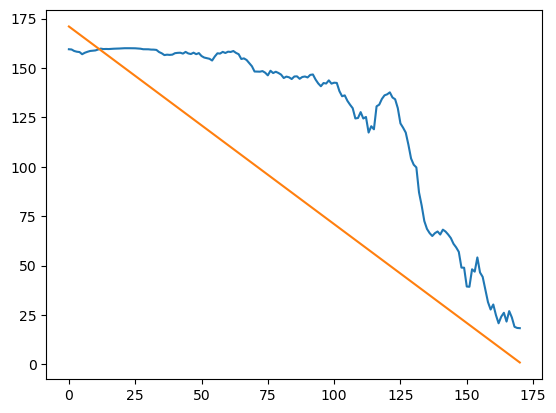

In [38]:
pred = model(X_train[:171].to(device)).detach().cpu().numpy()
plt.plot(pred)
plt.plot(y_train[:171].reshape(-1).numpy())

In [40]:
y_train_pred = model(X_train.to(device)).detach().cpu()
print("mean_squared_error >> ", mean_squared_error(y_train,y_train_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_train,y_train_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_train,y_train_pred))

mean_squared_error >>  1305.7906
root_mean_squared_error >>  36.13572538934375
mean_absolute_error >> 25.227781


# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [5]:
model = load_model('LSTM_with_lookback_20.h5')

In [6]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [7]:
df_rul = pd.read_csv(RUL_file, names=['rul'])
df_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [8]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
max_cycles[0] = max_cycles[0] - 21

In [9]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [10]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [11]:
df_test

array([[-1.7938502 ,  1.04936462,  1.00459956, ..., -0.43585161,
        -0.26636316,  0.42059548],
       [-1.75983242, -1.22056415, -1.03515135, ...,  0.37849296,
         0.89958112,  0.64708667],
       [-1.72609272,  0.14086219,  0.34489676, ...,  0.37849296,
         1.36106152,  0.96601877],
       ...,
       [ 1.83603259, -0.26773967, -1.03515135, ...,  1.88097691,
        -1.83688403, -1.50936271],
       [ 1.84590292, -1.71931856,  0.34489676, ...,  1.88097691,
        -1.59013861, -0.80455247],
       [ 1.85572407,  0.59502963,  1.00459956, ...,  2.57907106,
        -1.33736329, -1.7132478 ]])

In [12]:
X_test = np.array(df_test)

y_test = np.array(df_rul)



# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[ 10  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [13]:
def create_dataset(X, look_back=20):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

In [14]:
X_test = create_dataset(X_test)
#y_test = y_test[6:]

In [15]:
print(X_test.shape,y_test.shape)

(13075, 20, 17) (100, 1)


In [16]:
pred = model.predict(X_test)

In [17]:
pred.shape

(13075, 1)

In [18]:
final_pred = []
count = 0
for i in range(100):
    temp = 0
    j = max_cycles[i] 
    while j>0:
        temp = temp + pred[count]
        j=j-1
        count=count+1
    final_pred.append(int(temp/max_cycles[i]))

In [19]:
print(final_pred)

[116, 154, 84, 81, 97, 102, 118, 87, 100, 117, 29, 106, 115, 28, 150, 154, 49, 50, 120, 60, 89, 112, 153, 71, 86, 108, 115, 79, 138, 84, 40, 56, 80, 80, 45, 38, 95, 51, 84, 53, 83, 76, 81, 122, 82, 55, 26, 105, 99, 89, 99, 123, 89, 115, 146, 23, 76, 80, 120, 96, 61, 113, 77, 73, 64, 54, 87, 88, 95, 92, 63, 78, 112, 88, 94, 92, 66, 105, 99, 82, 39, 46, 94, 90, 89, 102, 129, 66, 95, 83, 38, 29, 63, 73, 91, 80, 55, 76, 134, 109]


In [20]:
final_pred[0]

116

## Using last index as prediction

In [23]:
def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

[108, 117, 20, 43, 48, 55, 102, 43, 105, 89, 26, 91, 104, 13, 191, 207, 25, 12, 152, 0, 53, 153, 100, 10, 123, 55, 48, 79, 57, 61, 0, 29, 61, 0, 0, 0, 14, 19, 114, 0, 26, 0, 34, 134, 36, 15, 44, 59, 0, 67, 57, 17, 14, 140, 173, 0, 65, 30, 66, 82, 5, 38, 41, 6, 82, 0, 87, 0, 91, 46, 38, 31, 113, 98, 60, 0, 23, 107, 57, 40, 0, 0, 80, 40, 123, 49, 81, 33, 47, 11, 0, 0, 13, 26, 78, 74, 57, 24, 117, 10]


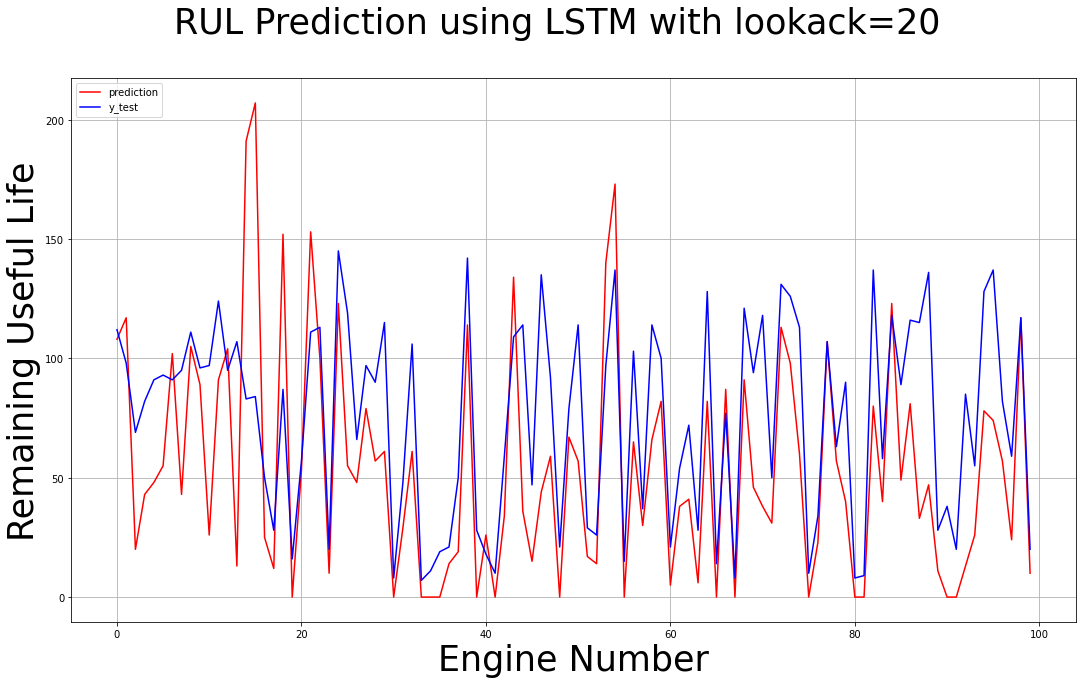

mean_squared_error >>  1629.12
root_mean_squared_error >>  40.362358702137314
mean_absolute_error >> 31.48
scoring function >> 276120.73887349915


In [24]:
final_pred = []
count = 0
for i in range(100):
    j = max_cycles[i] 
    temp = pred[count+j-1]
    count=count+j
    final_pred.append(int(temp))

print(final_pred)


fig = plt.figure(figsize=(18,10))
plt.plot(final_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using LSTM with lookack=20', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

print("mean_squared_error >> ", mean_squared_error(y_test,final_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,final_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,final_pred))
print("scoring function >>",scoring_function(y_test,final_pred))